In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import esmlab
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### Reading in Data

In [2]:
dir = '/glade/p/cesm/lmwg_dev/dll/CMIP6_CO2/CatCO2data/'
#note: 'CNRM-ESM2-1' uses r1k1p1f2 -- does this mean it's different in some way?

BCC_CSM2 = xr.open_dataset(dir + "co2_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc")
BCC_ESM1 = xr.open_dataset(dir + "co2_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc")
CNRM     = xr.open_dataset(dir + "co2_Amon_CNRM-ESM2-1_historical_r1i1p1f2_gr_185001-201412.nc")
GFDL     = xr.open_dataset(dir + "co2_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_185001-201412.nc")
MRI      = xr.open_dataset(dir + "co2_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc")
NorESM   = xr.open_dataset(dir + "co2_Amon_NorESM2-MM_historical_r1i1p1f1_gn_185001-201412.nc")
#CESM     = xr.open_dataset(dir + "co2_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc")
CESM     = xr.open_dataset(dir + "co2_Amon_CESM2_esm-hist_r1i1p1f1_gn_185001-201412.nc")


### Updating coordinates so math functions work properly

In [3]:
#coordinates are already properly set for CNRM
#BCC_CSM2 = BCC_CSM2.set_coords(['time_bnds', 'lat_bnds', 'lon_bnds'])
BCC_ESM1 = BCC_ESM1.set_coords(['time_bnds', 'lat_bnds', 'lon_bnds'])
#CNRM     = CNRM.set_coords(['time_bnds', 'lat_bnds', 'lon_bnds'])
GFDL     = GFDL.set_coords(['time_bnds', 'lat_bnds', 'lon_bnds'])
MRI      = MRI.set_coords(['time_bnds', 'lat_bnds', 'lon_bnds'])
NorESM   = NorESM.set_coords(['time_bnds', 'lat_bnds', 'lon_bnds'])
CESM     = CESM.set_coords(['time_bnds', 'lat_bnds', 'lon_bnds'])

In [4]:
#CESM

### Setting up dictionary for easier manipulation

In [5]:
co2_ds = dict()
#co2_ds['BCC_CSM2']  = BCC_CSM2.co2
co2_ds['BCC_ESM1']  = BCC_ESM1.co2
co2_ds['CNRM']      = CNRM.co2
co2_ds['GFDL']      = GFDL.co2
co2_ds['MRI']       = MRI.co2
co2_ds['NorESM']    = NorESM.co2
co2_ds['CESM']      = CESM.co2

In [ ]:
co2_ds

In [6]:
#converting to ppm
convert = 10.0**6

### Setting up arrays to subset points

In [ ]:
#Locations: Mauna Loa, Barrow, Niwot
lats=np.array([71.3,19.5,40.1])
lons=np.array([360-156.61,360-155.6,360-105.6])
pres=np.array([68000, 99800, 70000])

### Testing model and location subsets to determine maximum CO2 concentrations 

In [ ]:
#Locations: Mauna Loa=0, Barrow=1, Niwot=2
x=0
test = []
test = co2_ds['CESM'].sel(lat=lats[x],lon=lons[x], plev=pres[x], method='nearest')
#test = co2_ds['CESM'].sel(lat=slice(30,90))
test = test.isel(time=slice(-60, None))*convert
#test = test.isel(time=slice(-60, None), plev=1)*convert
test.max()

### Observational Data

In [7]:
path='/glade/work/dll/CTSM_py/notebooks/'
brw={'name':'Barrow', 'acronym': 'brw',  'lat': 71.3, 'lon':360-156.61, 'z': 11.0}
mlo={'name':'Mauna Loa', 'acronym': 'mlo', 'lat': 19.5, 'lon':360-155.6, 'z':3397.0}
nwr={'name':'Niwot Ridge', 'acronym':'nwr', 'lat':40.1, 'lon':360-105.6, 'z':3523.0}

In [8]:
ESRL=[brw, mlo, nwr]

In [9]:
dfs = []

for site in ESRL:
#    print(site)
    filename=path+'co2_'+site['acronym']+'_surface-flask_1_ccgg_month.txt'
    #import glob
    #filename=glob.glob(partialname+ '*co2')
    with open(filename, 'r') as fid:
        first_line=fid.readline()
        nheader=first_line[-3:-1]
        nheader=np.int(np.float(nheader))
    data=np.loadtxt(filename, usecols=(1,2,3), skiprows=nheader)
    time=data[:,0]+data[:,1]/12
    co2=data[:,2]
    month=data[:,1]
    year=data[:,0]
    site['year']=year.astype(int)
    site['month']=month.astype(int)
    site['co2']=co2
    dfs.append(pd.DataFrame(site)) #turn dictionary into a pandas dataframe
    
    print(site['acronym']+' first year '+str(min(year)) +' last year '+str(max(year)))
    
df = pd.concat(dfs)
df['time'] = pd.to_datetime(df.year.astype('str') + '-' + df.month.astype('str'))

brw first year 1971.0 last year 2018.0
mlo first year 1959.0 last year 2018.0
nwr first year 1968.0 last year 2019.0


### Calculating Observation Amplitude

In [10]:
ds = df.set_index(['time', 'name'])[['co2']].to_xarray()

grouped = ds.groupby('name')
dsets = []
for site, dataset in grouped:
    g = dataset.groupby('time.year')
    r = (g.max() - g.min())
    dsets.append(r)

x = xr.concat(dsets, dim='name')

### Pulling out site locations

In [11]:
ml_nbp = {}
bar_nbp = {}
nwt_nbp = {}

ml_nbp_mean = {}
ml_nbp_std = {}
ml_pct_diff = {}
bar_nbp_mean = {}
bar_nbp_std = {}
bar_pct_diff = {}
nwt_nbp_mean = {}
nwt_nbp_std = {}
nwt_pct_diff = {}

for sim_name, data in co2_ds.items():
    ml_nbp[sim_name] = data.sel(lat=19.5,lon=204.4, plev=70000, method='nearest')* convert
    bar_nbp[sim_name] = data.sel(lat=71.3,lon=203.4, plev=92500, method='nearest')* convert
    nwt_nbp[sim_name] = data.sel(lat=40.1,lon=254.4, plev=70000, method='nearest')* convert

### Calculating CMIP6 amplitude time series and 2000-2015 mean and error for each location

In [12]:
# Mauna Loa
for sim_name, data in ml_nbp.items():
    co2amp = data.resample(time="Y").max() - data.resample(time="Y").min()
    ml_nbp[sim_name] = co2amp
    co2_mean_amp = co2amp.sel(time=slice("2010", "2015")).mean()
    ml_nbp_mean[sim_name] = co2_mean_amp
    co2_std_amp = co2amp.isel(time=slice(-60, None)).std()
    ml_nbp_std[sim_name] = co2_std_amp
    ml_pct_diff[sim_name] = (co2amp.sel(time=slice("2010", "2015")).mean() - co2amp.sel(time=slice("1970", "1975")).mean())/(co2amp.sel(time=slice("1970", "1975")).mean())*100

In [ ]:
ml_nbp_mean['obs']

In [13]:
# Barrow
for sim_name, data in bar_nbp.items():
    co2amp = data.resample(time="Y").max() - data.resample(time="Y").min()
    bar_nbp[sim_name] = co2amp
    bar_nbp_mean[sim_name]= co2amp.sel(time=slice("2010", "2015")).mean()
    bar_nbp_std[sim_name] = co2amp.sel(time=slice("2010", "2015")).std()
    bar_pct_diff[sim_name] = (co2amp.sel(time=slice("2010", "2015")).mean() - co2amp.sel(time=slice("1970", "1975")).mean())/(co2amp.sel(time=slice("1970", "1975")).mean())*100

In [14]:
# Niwot Ridge
for sim_name, data in nwt_nbp.items():
    co2amp = data.resample(time="Y").max() - data.resample(time="Y").min()
    nwt_nbp[sim_name] = co2amp
    nwt_nbp_mean[sim_name] = co2amp.sel(time=slice("2010", "2015")).mean()
    nwt_nbp_std[sim_name] = co2amp.sel(time=slice("2010", "2015")).std()
    nwt_pct_diff[sim_name] = (co2amp.sel(time=slice("2010", "2015")).mean() - co2amp.sel(time=slice("1975", "1980")).mean())/(co2amp.sel(time=slice("1975", "1980")).mean())*100

### Plotting mean amplitude averaged for 2000-2015

In [ ]:
#quick error check
plt.figure(figsize=(10,3))
plt.bar(*zip(*bar_nbp_mean.items()))
plt.show()

### Calculating observational amplitude time series and 2000-2015 mean and error for each location

In [15]:
mllate = x.sel(name=("Mauna Loa"), year=slice("2010", "2015")).mean()
mlstd = x.sel(name=("Mauna Loa"), year=slice("2010", "2015")).std()
mlearly = x.sel(name=("Mauna Loa"),year=slice("1970", "1975")).mean()
mlpctdiff = (mllate-mlearly)/mlearly*100

barlate = x.sel(name=("Barrow"), year=slice("2010", "2015")).mean()
barstd = x.sel(name=("Barrow"), year=slice("2010", "2015")).std()
barearly = x.sel(name=("Barrow"),year=slice("1970", "1975")).mean()
barpctdiff = (barlate-barearly)/barearly*100

nwtlate = x.sel(name=("Niwot Ridge"), year=slice("2010", "2015")).mean()
nwtstd = x.sel(name=("Niwot Ridge"), year=slice("2010", "2015")).std()
nwtearly = x.sel(name=("Niwot Ridge"),year=slice("1975", "1980")).mean()
nwtpctdiff = (nwtlate-nwtearly)/nwtearly*100

### Adding observations to CMIP6 dictionary

In [16]:
ml_nbp_mean['obs'] = mllate.to_array
ml_nbp_std['obs'] = mlstd.to_array
ml_pct_diff['obs'] = mlpctdiff.to_array

### Plotting amplitude vs change in amplitude at each site
Note: observations cause plotting error

TypeError: float() argument must be a string or a number, not 'method'

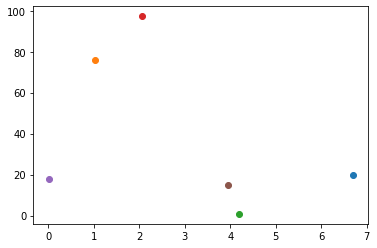

In [17]:
# Note: error related to plotting obs value
fig, ax = plt.subplots()
for k in ml_nbp_mean.keys():
    ax.plot(ml_nbp_mean[k], ml_pct_diff[k], marker='o')
ax.set_ylabel("% Change in 2010-2015 from 1960-1965")
ax.set_xlabel("2010-2015 Amplitude")
ax.legend(ml_nbp_mean.keys())
plt.title('Mauna Loa')

#plt.savefig('CMIP6_MLO.pdf')

Text(0.5, 1.0, 'Barrow')

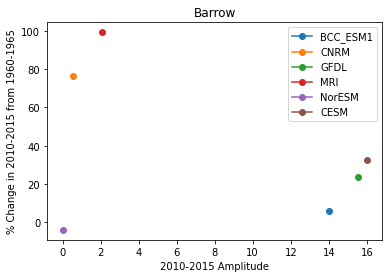

In [18]:
fig, ax = plt.subplots()
for k in bar_nbp_mean.keys():
    ax.plot(bar_nbp_mean[k], bar_pct_diff[k], marker='o')
ax.set_ylabel("% Change in 2010-2015 from 1960-1965")
ax.set_xlabel("2010-2015 Amplitude")  
ax.legend(bar_nbp_mean.keys())
plt.title('Barrow')

#plt.savefig('CMIP6_BRW.pdf')

Text(0.5, 1.0, 'Niwot Ridge')

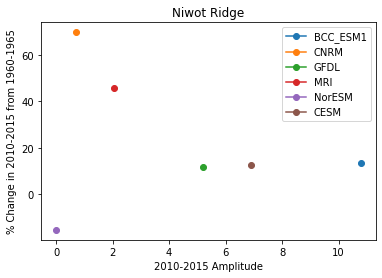

In [19]:
fig, ax = plt.subplots()
for k in nwt_nbp_mean.keys():
    ax.plot(nwt_nbp_mean[k], nwt_pct_diff[k], marker='o')
ax.set_ylabel("% Change in 2010-2015 from 1960-1965")
ax.set_xlabel("2010-2015 Amplitude")  
ax.legend(nwt_nbp_mean.keys())
plt.title('Niwot Ridge')

#plt.savefig('CMIP6_NWT.pdf')

In [ ]:
#This also works for a quick look, but all markers are the same color
fig, ax = plt.subplots()
ax.scatter(ml_nbp_mean.values(), ml_pct_diff.values(), marker = 'o')
ax.set_ylabel("Percent Change from 1960-1965")
ax.set_xlabel("2010-2015 Amplitude")